# VR Study Dashboard

## Imports, Settings & Functions

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
from dash import dash_table
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import dash.dependencies
import plotly.io as pio
import math
from plotly.subplots import make_subplots
from plotly.graph_objs import *

import json
# code and plot setup
# settings
pd.options.plotting.backend = "plotly"
#external_stylesheets = ['https://bootswatch.com/5/morph/bootstrap.min.css']
external_stylesheets = ['https://bootswatch.com/5/flatly/bootstrap.min.css']
pio.templates.default = "simple_white"#seaborn plotly_dark

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

COLOR_SIT_N_HEX = "#FFFFFF"
COLOR_SIT_A_HEX = "#7a5b7b"
COLOR_SIT_B_HEX = "#f9dbbd"
COLOR_SIT_C_HEX = "#fca17d"
COLOR_SIT_D_HEX = "#68534d"
COLOR_SIT_E_HEX = "#5b7b7a"
COLOR_SIT_X_HEX = "#8f2d41"

marking_red = "#961C26"   #'#B90F22'

#Plot Layout for no background
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

/usr/local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#df_raw = load_tsv('./logs_vr/subject6_2022-06-29_153217_Condition_0.tsv')
#df = read_data('./logs_vr/subject6_2022-06-29_153217_Condition_0.tsv')

In [3]:
#display(df_raw["timestamp"])
#display(df.index)

In [4]:
# functions
def load_tsv(path):
    df = pd.read_csv(path,sep='\t');
    # dframe.drop(dframe[dframe.type.str.contains("_ex")].index, inplace=True) -> TO Drop specific lines!
    return df
def load_csv(path):
    df = pd.read_csv(path,sep=';');
    return df

def read_data(path):
    df = load_tsv(path)
    
    # normalize timestamp to start at 0
    firstTimestamp = df["timestamp"].iloc[0]
    df["timestamp"] = df.apply(lambda x: x["timestamp"] - firstTimestamp,axis=1)
    
    # Timestamps from miliseconds to seconds
    df["timestamp"] = df.apply(lambda x: x["timestamp"] / 1000,axis=1)
    
    #Timestamps as index
    df.set_index('timestamp',inplace=True)
    
    #Cutting 0 FPS columns because irrelevant
#    df = df.loc[df['fps'] > 0]
    
#    df = df.apply(pd.to_numeric, errors='coerce')
    #rework boolean for plotting
    df.replace({False: 0, True: 1}, inplace=True)
    
    addRotations(df)
    return df
def add_conditions(subject,fig,propertyName):
    shapes = []
    intersections = subjects[subject][["intersection"]]
    #mark the rows where the content changes
    changes = intersections["intersection"].shift() != intersections["intersection"]
    #get the rows where the change happens
    changeRows = intersections.loc[changes[changes].index, :]
    lastElem = intersections.iloc[0]

    #create axspan for each
    for index, row in changeRows.iterrows():
        if index > 0:
            condition = conditions.loc[conditions["intersection"] == lastElem[1]["intersection"]]    
            #Colors..
            if lastElem[1]["intersection"] == "NONE":
                lastElem = [index,row]
                continue
            elif  condition.empty:
                color = COLOR_SIT_X_HEX
            elif  condition["condition"].values[0] == 'x':
                color = COLOR_SIT_X_HEX
            elif  condition["condition"].values[0] == 'a':
                color = COLOR_SIT_A_HEX
            elif  condition["condition"].values[0] == 'b':
                color = COLOR_SIT_B_HEX
            elif  condition["condition"].values[0] == 'c':
                color = COLOR_SIT_C_HEX
            elif  condition["condition"].values[0] == 'd':
                color = COLOR_SIT_D_HEX
            elif  condition["condition"].values[0] == 'e':
                color = COLOR_SIT_E_HEX
            shapes.append({
                'type': 'rect',
    #            xref: 'x',
    #            yref: 'paper',
                'x0': lastElem[0],
                'y0': subjects[subject][propertyName].min(),
                'x1': index,
                'y1': subjects[subject][propertyName].max(),
                'fillcolor': color,
                'opacity': 0.5,
                'line': {
                    'width': 0
                }
            })
        lastElem = [index,row]
    fig.update_layout(shapes = shapes)
#Creates a dict containing every situation. For every situation containing a list with tuples of start and endpoints per single situation
def getSituationSplits(df):
    intersections = df[["intersection"]]
    #mark the rows where the content changes
    changes = intersections["intersection"].shift() != intersections["intersection"]
    #get the rows where the change happens
    changeRows = intersections.loc[changes[changes].index, :]
    lastElem = intersections.iloc[0]
    
    times = {
        "none" : [],
        "x" : [],
        "a" : [],
        "b" : [],
        "c" : [],
        "d" : [],
        "e" : []
    }
    
    #create axspan for each
    for index, row in changeRows.iterrows():
        if index > 0:
            condition = conditions.loc[conditions["intersection"] == lastElem[1]["intersection"]]    
            if lastElem[1]["intersection"] == "NONE":
                times["none"].append((lastElem[0],index))
            elif  condition.empty:
                times["none"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'x':
                times["x"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'a':
                times["a"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'b':
                times["b"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'c':
                times["c"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'd':
                times["d"].append((lastElem[0],index))
            elif  condition["condition"].values[0] == 'e':
                times["e"].append((lastElem[0],index))
        lastElem = [index,row]
    return times
def getAverageOfSplit(situation,subject):
    display([
        subject_splits[subject][situation][0][1] - subject_splits[subject][situation][0][0],
        subject_splits[subject][situation][1][1] - subject_splits[subject][situation][1][0],
        subject_splits[subject][situation][2][1] - subject_splits[subject][situation][2][0]
    ])
    return np.mean([
        subject_splits[subject][situation][0][1] - subject_splits[subject][situation][0][0],
        subject_splits[subject][situation][1][1] - subject_splits[subject][situation][1][0],
        subject_splits[subject][situation][2][1] - subject_splits[subject][situation][2][0]
    ])
# adds two rows to the dataframe. rotations which indicates the rotation for each row, group_index which indicates to which look count the row is sorted (1 group = 1 look)
def addRotations(df):
    rotation_threshhold = 20.0
    df["rotation"] = "x"
    df.loc[(df["hmdRotationY"] > rotation_threshhold),"rotation"] = "r"
    df.loc[(df["hmdRotationY"] < -rotation_threshhold),"rotation"] = "l"
    df['group_index'] = (df['rotation'] != df['rotation'].shift()).cumsum()
    
#Returns the rotations for each situation for given subject
def getRotations(subject):
    rotations = {
        "a" : [],
        "b" : [],
        "c" : [],
        "d" : [],
        "e" : []
    }    
    for key,values in rotations.items():
        for split_sit in subject_splits[subject][key]:
            rot_groups = subjects[subject][split_sit[0]:split_sit[1]].groupby(['rotation'])["group_index"]
            rots = subjects[subject][split_sit[0]:split_sit[1]].groupby(['rotation'])["group_index"].nunique()
            values.append((rots.get("l" , 0),rots.get("r" , 0)))
    return rotations
def getAngles(subject):
    situation_angles = []
    # For every Situation...
    for key in ["a","b","c","d","e"]:
        #for every iteration of this situation
        for index,split_sit in enumerate(subject_splits[subject][key]):
            rot_groups = subjects[subject][split_sit[0]:split_sit[1]][["rotation","hmdRotationY","group_index"]]#.groupby(['rotation'])["group_index"]
            rot_groups.groupby(['rotation'])
            # for every found headrotation
            for group in rot_groups["group_index"].unique():
                df_group = rot_groups.loc[rot_groups["group_index"] == group]
                if 'l' in df_group["rotation"].unique():
                    situation_angles.append((key,index,"left",df_group["hmdRotationY"].min()))
                elif 'r' in df_group["rotation"].unique():
                    situation_angles.append((key,index,"right",df_group["hmdRotationY"].max()))
    return np.array(situation_angles,dtype = ([('situation', 'U10'),('iteration', 'i4'),('direction', 'U10'), ('angle', 'f4')]))
def getCollisions(subject):
    crashCount = {
        "none" : 0,
        "x" : 0,
        "a" : 0,
        "b" : 0,
        "c" : 0,
        "d" : 0,
        "e" : 0
    }
    crashes = subjects[subject][["collisions","intersection"]].loc[subjects[subject]["collisions"] != 0]   
    for index,row in crashes.iterrows():
        if row["intersection"] in conditions["intersection"].unique():
            condition = conditions.loc[conditions["intersection"] == row["intersection"]]["condition"].iloc[0]
            crashCount[condition] = crashCount[condition] + 1
    return crashCount
# Returns per situation the mean of all (3) situations which contain the sum of all occured stand incidents (speedsensor = 0) in the situation
def getStandtimes(subject):
    situation_stands = []
    for situation in ["a","b","c","e"]:
        #for every iteration of this situation
        for index,split_sit in enumerate(subject_splits[subject][situation]):
            df_timeslice = subjects[subject].loc[split_sit[0]:split_sit[1]]["speed"]
            group_index = (df_timeslice != df_timeslice.shift()).cumsum()
            # for every found headrotation
            standedInIteration = False
            for stand_sit_group in group_index.unique():
                df_sit = group_index.loc[group_index == stand_sit_group]
                if df_timeslice[df_sit.index[0]] == 0.0:
                    situation_stands.append((situation,index,df_sit.index[-1] - df_sit.index[0]))
                    standedInIteration = True
            if not standedInIteration:
                # This iteration no one stand. Adding 0 to account for in mean calculations
                situation_stands.append((situation,index,0.00))
    return np.array(situation_stands,dtype = ([('situation', 'U10'),('iteration', 'i4'), ('seconds', 'f4')]))

# builds sum over all iterations of one situation, returns mean of this sum
def getMeanOfStandSituation(times,situation):
    sit_times = times[times["situation"] == situation]
    sit_sums = []
    for iteration in np.unique(sit_times["iteration"]):
        sit_sums.append(np.sum(sit_times[sit_times["iteration"] == iteration]["seconds"]))
    return np.mean(sit_sums)

In [5]:
#display(df_subject2[386.544:402.384]["speed"])
#times = getStandtimes("Subject 2")
#display(times)
#display(getMeanOfStandSituation(times,"e"))
#display(times[times["situation"] == "e"])
#display(getAverageOfSplit("e","Subject 2"))
#display(subject_splits["Subject 2"]["e"])

## Data Read

In [6]:
#Global read conditions
conditions = load_csv("./logs_vr/conditions.csv")

df_subject1 = read_data('./logs_vr/subject1_2022-06-28_103935_Condition_0.tsv')
df_subject2 = read_data('./logs_vr/subject2_2022-06-28_152542_Condition_0.tsv')
df_subject3 = read_data('./logs_vr/subject3_2022-06-28_164830_Condition_0.tsv')
df_subject4 = read_data('./logs_vr/subject4_2022-06-29_134215_Condition_0.tsv')
df_subject5 = read_data('./logs_vr/subject5_2022-06-29_143922_Condition_0.tsv')
df_subject6 = read_data('./logs_vr/subject6_2022-06-29_153217_Condition_0.tsv')
df_subject7 = read_data('./logs_vr/subject7_2022-06-30_133951_Condition_0.tsv')
df_subject8= read_data('./logs_vr/subject8_2022-07-05_161117_Condition_0.tsv')
df_subject9= read_data('./logs_vr/subject9_2022-07-05_171811_Condition_0.tsv')
df_subject10 = read_data('./logs_vr/subject10_2022-07-05_175819_Condition_0.tsv')
df_subject11 = read_data('./logs_vr/subject11_2022-07-06_134238_Condition_0.tsv')
df_subject12 = read_data('./logs_vr/subject12_2022-07-08_111356_Condition_0.tsv')

/var/folders/y1/pzrsgg_929sbhzsnn2yjtgv80000gn/T/ipykernel_37352/581279585.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t');


In [7]:
subjects = {
    "Subject 1" : df_subject1,
    "Subject 2" : df_subject2,
    "Subject 3" : df_subject3,
    "Subject 4" : df_subject4,
    "Subject 5" : df_subject5,
    "Subject 6" : df_subject6,
    "Subject 7" : df_subject7,
    "Subject 8" : df_subject8,
    "Subject 9" : df_subject9,
    "Subject 10" : df_subject10,
    "Subject 11" : df_subject11,
    "Subject 12" : df_subject12
}
subject_splits = {
    "Subject 1" : getSituationSplits(df_subject1),
    "Subject 2" : getSituationSplits(df_subject2),
    "Subject 3" : getSituationSplits(df_subject3),
    "Subject 4" : getSituationSplits(df_subject4),
    "Subject 5" : getSituationSplits(df_subject5),
    "Subject 6" : getSituationSplits(df_subject6),
    "Subject 7" : getSituationSplits(df_subject7),
    "Subject 8" : getSituationSplits(df_subject8),
    "Subject 9" : getSituationSplits(df_subject9),
    "Subject 10" : getSituationSplits(df_subject10),
    "Subject 11" : getSituationSplits(df_subject11),
    "Subject 12" : getSituationSplits(df_subject12)
}
#[difficulty,safety]
subjects_perceived = {
    "Subject 1" :  [[5,1,3,3,1],[4,4,3,3,5]],
    "Subject 2" :  [[2,3,2,2,4],[4,2,4,2,1]],
    "Subject 3" :  [[3,1,2,2,4],[2,5,4,4,3]],
    "Subject 4" :  [[2,2,5,4,3],[4,4,1,1,2]],
    "Subject 5" :  [[2,2,3,4,4],[4,5,2,4,2]],
    "Subject 6" :  [[2,1,1,5,5],[2,2,4,5,1]],
    "Subject 7" :  [[4,1,3,4,2],[4,5,3,2,4]],
    "Subject 8" :  [[4,1,4,2,5],[1,4,2,5,1]],
    "Subject 9" :  [[2,1,4,5,5],[4,3,2,2,2]],
    "Subject 10" : [[1,3,2,4,4],[5,3,4,3,2]],
    "Subject 11" : [[4,2,3,5,3],[2,4,4,1,3]],
    "Subject 12" : [[4,2,5,3,2],[1,5,1,3,4]],
}

available_data_labels = list(subjects.keys())

In [8]:
data = []
for key,value in subjects.items():
    rotations = getRotations(key)
    collisions = getCollisions(key)
    standtimes = getStandtimes(key)
    angles = getAngles(key)
    left_angles = angles[(angles["situation"] == key) & (angles["direction"] == "left")]["angle"]
    right_angles = angles[(angles["situation"] == key) & (angles["direction"] == "right")]["angle"]
    data.append([
        key,
        value["hmdRotationY"].mean(axis=0),
        value["speed"].mean(axis=0),
        value.index[-1],
        getAverageOfSplit("a",key),
        getAverageOfSplit("b",key),
        getAverageOfSplit("c",key),
        0,
        getAverageOfSplit("e",key),
        getMeanOfStandSituation(standtimes,"a"),
        getMeanOfStandSituation(standtimes,"b"),
        getMeanOfStandSituation(standtimes,"c"),
        0,
        getMeanOfStandSituation(standtimes,"e"),
        collisions["a"],
        collisions["b"],
        collisions["c"],
        0,
        collisions["e"],
        np.sum([i[0] for i in rotations["a"]]) / len(rotations["a"]),
        np.sum([i[0] for i in rotations["b"]])/ len(rotations["a"]),
        np.sum([i[0] for i in rotations["c"]])/ len(rotations["a"]),
        0,
        np.sum([i[0] for i in rotations["e"]])/ len(rotations["a"]),
        np.sum([i[1] for i in rotations["a"]])/ len(rotations["a"]),
        np.sum([i[1] for i in rotations["b"]])/ len(rotations["a"]),
        np.sum([i[1] for i in rotations["c"]])/ len(rotations["a"]),
        0,
        np.sum([i[1] for i in rotations["e"]])/ len(rotations["a"]),
        np.mean(angles[(angles["situation"] == "a") & (angles["direction"] == "left")]["angle"]),
        np.mean(angles[(angles["situation"] == "b") & (angles["direction"] == "left")]["angle"]),
        np.mean(angles[(angles["situation"] == "c") & (angles["direction"] == "left")]["angle"]),
        0,
        np.mean(angles[(angles["situation"] == "e") & (angles["direction"] == "left")]["angle"]),
        np.mean(angles[(angles["situation"] == "a") & (angles["direction"] == "right")]["angle"]),
        np.mean(angles[(angles["situation"] == "b") & (angles["direction"] == "right")]["angle"]),
        np.mean(angles[(angles["situation"] == "c") & (angles["direction"] == "right")]["angle"]),
        0,
        np.mean(angles[(angles["situation"] == "e") & (angles["direction"] == "right")]["angle"]),
        #safety
        subjects_perceived[key][1][0],
        subjects_perceived[key][1][1],
        subjects_perceived[key][1][2],
        subjects_perceived[key][1][3],
        subjects_perceived[key][1][4],
        #difficulty
        subjects_perceived[key][0][0],
        subjects_perceived[key][0][1],
        subjects_perceived[key][0][2],
        subjects_perceived[key][0][3],
        subjects_perceived[key][0][4]
    ])
df_all = pd.DataFrame(data, columns=[
    'subject', 
    'mean_rotation',
    'mean_speed',
    "duration",
    'sit_a_duration',
    'sit_b_duration',
    'sit_c_duration',
    'sit_d_duration',
    'sit_e_duration',
    'sit_a_standtime',
    'sit_b_standtime',
    'sit_c_standtime',
    'sit_d_standtime',
    'sit_e_standtime',
    'sit_a_collisions',
    'sit_b_collisions',
    'sit_c_collisions',
    'sit_d_collisions',
    'sit_e_collisions',
    'sit_a_left_rotations',
    'sit_b_left_rotations',
    'sit_c_left_rotations',
    'sit_d_left_rotations',
    'sit_e_left_rotations',
    'sit_a_right_rotations',
    'sit_b_right_rotations',
    'sit_c_right_rotations',
    'sit_d_right_rotations',
    'sit_e_right_rotations',
    'sit_a_left_angle',
    'sit_b_left_angle',
    'sit_c_left_angle',
    'sit_d_left_angle',
    'sit_e_left_angle',
    'sit_a_right_angle',
    'sit_b_right_angle',
    'sit_c_right_angle',
    'sit_d_right_angle',
    'sit_e_right_angle',
    "sit_a_safety",
    "sit_b_safety",
    "sit_c_safety",
    "sit_d_safety",
    "sit_e_safety",
    "sit_a_difficulty",
    "sit_b_difficulty",
    "sit_c_difficulty",
    "sit_d_difficulty",
    "sit_e_difficulty"
])
df_all.loc['Total'] = df_all.mean(numeric_only=True)
#df_all.loc['SD'] = df_all.std(numeric_only=True)

[7.149000000000001, 39.94900000000001, 5.251999999999953]

[10.473000000000013, 6.7409999999999854, 5.795000000000073]

[24.31, 27.735000000000014, 9.001999999999953]

[6.844000000000008, 15.393000000000029, 23.502999999999986]

[26.48599999999999, 19.918999999999983, 27.59299999999996]

[5.388999999999953, 4.661000000000058, 4.448999999999955]

[13.379000000000001, 26.620000000000005, 12.586999999999989]

[64.52799999999999, 29.64300000000003, 5.162000000000035]

[23.091000000000008, 4.135999999999996, 37.17700000000002]

[6.1089999999999804, 4.249000000000024, 4.8700000000000045]

[10.276000000000003, 9.734000000000037, 11.098999999999933]

[5.736000000000004, 3.9569999999999936, 4.5]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[61.65899999999999, 69.39599999999996, 9.626999999999953]

[18.502999999999986, 12.621999999999957, 7.199000000000069]

[40.869, 68.65100000000007, 29.988000000000056]

[10.198000000000008, 28.488000000000056, 23.682000000000016]

[24.908999999999992, 23.903999999999996, 38.52099999999996]

[6.066000000000031, 14.17100000000005, 18.839000000000055]

[47.179, 40.09800000000007, 15.116999999999962]

[23.062999999999988, 36.56999999999999, 27.028999999999996]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[23.749000000000024, 33.339000000000055, 18.825000000000045]

[10.625, 10.571000000000026, 4.731999999999971]

[13.073000000000008, 24.115999999999985, 29.764999999999986]

[55.232, 5.680999999999926, 6.052999999999997]

[14.995000000000005, 13.928999999999974, 10.471000000000004]

[5.260999999999996, 5.9360000000000355, 5.399999999999977]

[18.241999999999997, 11.560000000000002, 7.966000000000008]

[5.557000000000002, 6.896999999999991, 6.965000000000032]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[12.86699999999999, 57.85799999999995, 27.659999999999968]

[12.735000000000014, 7.309999999999945, 5.125]

[11.547, 14.20799999999997, 8.156000000000063]

[4.647999999999996, 4.447000000000003, 6.427999999999997]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[20.91300000000001, 44.905000000000086, 26.77299999999991]

[13.541999999999973, 2.6210000000000946, 20.41999999999996]

[32.128, 32.039999999999964, 7.846000000000004]

[41.016999999999996, 26.763000000000034, 44.69200000000001]

[13.455000000000013, 22.091000000000008, 29.10699999999997]

[6.447000000000003, 9.601999999999975, 4.168999999999983]

[10.700000000000003, 20.611000000000047, 11.428999999999974]

[7.606999999999999, 10.036000000000001, 7.329999999999984]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[7.828000000000003, 41.10700000000003, 24.104000000000042]

[5.596000000000004, 10.547000000000025, 4.514999999999986]

[26.403000000000002, 17.149, 19.980999999999995]

[5.873999999999995, 13.011000000000024, 6.109000000000037]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[67.03300000000002, 14.464999999999975, 40.46399999999994]

[12.194999999999993, 7.826000000000022, 7.810000000000059]

[25.627000000000002, 14.493000000000052, 71.11399999999992]

[7.697000000000003, 24.187999999999988, 9.416999999999916]

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
#Correlations
data = []
for key,value in subjects.items():
    rotations = getRotations(key)
    collisions = getCollisions(key)
    standtimes = getStandtimes(key)
    angles = getAngles(key)
    left_angles = angles[(angles["situation"] == key) & (angles["direction"] == "left")]["angle"]
    right_angles = angles[(angles["situation"] == key) & (angles["direction"] == "right")]["angle"]
    data.append([
        key,
        #Rotations have to be divided by the iterations. We need amount
        [i[0] for i in rotations["a"]],
        [i[0] for i in rotations["b"]],
        [i[0] for i in rotations["c"]],
        0,
        [i[0] for i in rotations["e"]],
        [i[1] for i in rotations["a"]],
        [i[1] for i in rotations["b"]],
        [i[1] for i in rotations["c"]],
        0,
        [i[1] for i in rotations["e"]],
        angles[(angles["situation"] == "a") & (angles["direction"] == "left")]["angle"],
        angles[(angles["situation"] == "b") & (angles["direction"] == "left")]["angle"],
        angles[(angles["situation"] == "c") & (angles["direction"] == "left")]["angle"],
        0,
        angles[(angles["situation"] == "e") & (angles["direction"] == "left")]["angle"],
        angles[(angles["situation"] == "a") & (angles["direction"] == "right")]["angle"],
        angles[(angles["situation"] == "b") & (angles["direction"] == "right")]["angle"],
        angles[(angles["situation"] == "c") & (angles["direction"] == "right")]["angle"],
        0,
        angles[(angles["situation"] == "e") & (angles["direction"] == "right")]["angle"],
        #safety
        subjects_perceived[key][1][0],
        subjects_perceived[key][1][1],
        subjects_perceived[key][1][2],
        subjects_perceived[key][1][3],
        subjects_perceived[key][1][4],
        #difficulty
        subjects_perceived[key][0][0],
        subjects_perceived[key][0][1],
        subjects_perceived[key][0][2],
        subjects_perceived[key][0][3],
        subjects_perceived[key][0][4]
    ])
df_corr = pd.DataFrame(data, columns=[
    'subject', 
    'sit_a_left_rotations',
    'sit_b_left_rotations',
    'sit_c_left_rotations',
    'sit_d_left_rotations',
    'sit_e_left_rotations',
    'sit_a_right_rotations',
    'sit_b_right_rotations',
    'sit_c_right_rotations',
    'sit_d_right_rotations',
    'sit_e_right_rotations',
    'sit_a_left_angle',
    'sit_b_left_angle',
    'sit_c_left_angle',
    'sit_d_left_angle',
    'sit_e_left_angle',
    'sit_a_right_angle',
    'sit_b_right_angle',
    'sit_c_right_angle',
    'sit_d_right_angle',
    'sit_e_right_angle',
    "sit_a_safety",
    "sit_b_safety",
    "sit_c_safety",
    "sit_d_safety",
    "sit_e_safety",
    "sit_a_difficulty",
    "sit_b_difficulty",
    "sit_c_difficulty",
    "sit_d_difficulty",
    "sit_e_difficulty"
])

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

left_rots = []
safety_left_rots = []
right_rots = []
safety_right_rots = []
left_angles = []
safety_left_angles = []
right_angles = []
safety_right_angles = []

safety = []
difficulty = []
for index,participant in df_corr.iterrows():
    for situation in ["a","c","e"]:
        #Rotations
        for left_rot in participant["sit_"+situation+"_left_rotations"]:
            left_rots.append(left_rot)
            safety_left_rots.append(participant["sit_"+situation+"_safety"])
        
        for right_rot in participant["sit_"+situation+"_right_rotations"]:
            right_rots.append(right_rot)
            safety_right_rots.append(participant["sit_"+situation+"_safety"])

        #Angles
        for left_angle in participant["sit_"+situation+"_left_angle"]:
            left_angles.append(left_angle)
            safety_left_angles.append(participant["sit_"+situation+"_safety"])
        
        for right_angle in participant["sit_"+situation+"_right_angle"]:
            right_angles.append(right_angle)
            safety_right_angles.append(participant["sit_"+situation+"_safety"])
        
        safety.append(participant["sit_"+situation+"_safety"])
        difficulty.append(participant["sit_"+situation+"_difficulty"])

In [10]:
totals = df_all.loc["Total"]
data = [
    ["A",totals["sit_a_duration"],totals["sit_a_standtime"],0,totals["sit_a_left_rotations"],totals["sit_a_right_rotations"],totals["sit_a_left_angle"],totals["sit_a_right_angle"],totals["sit_a_collisions"],totals["sit_a_safety"],totals["sit_a_difficulty"]],
    ["B",totals["sit_b_duration"],totals["sit_b_standtime"],0,totals["sit_b_left_rotations"],totals["sit_b_right_rotations"],totals["sit_b_left_angle"],totals["sit_b_right_angle"],totals["sit_b_collisions"],totals["sit_b_safety"],totals["sit_b_difficulty"]],
    ["C",totals["sit_c_duration"],totals["sit_c_standtime"],0,totals["sit_c_left_rotations"],totals["sit_c_right_rotations"],totals["sit_c_left_angle"],totals["sit_c_right_angle"],totals["sit_c_collisions"],totals["sit_c_safety"],totals["sit_c_difficulty"]],
#    ["d",totals["sit_d_duration"],totals["sit_d_standtime"],0,totals["sit_d_left_rotations"],totals["sit_d_right_rotations"],totals["sit_d_left_angle"],totals["sit_d_right_angle"],totals["sit_d_collisions"]],
    ["D",totals["sit_e_duration"],totals["sit_e_standtime"],0,totals["sit_e_left_rotations"],totals["sit_e_right_rotations"],totals["sit_e_left_angle"],totals["sit_e_right_angle"],totals["sit_e_collisions"],totals["sit_e_safety"],totals["sit_e_difficulty"]]
]
df_means_situations = pd.DataFrame(data, columns=[
    'situation',
    'duration', 
    'standtime',
    'speed',
    'left_looks',
    'right_looks',
    'left_angles',
    'right_angles',
    'collisions',
    'safety',
    'difficulty'
])

### Mean Plots

#### Headrotation Count

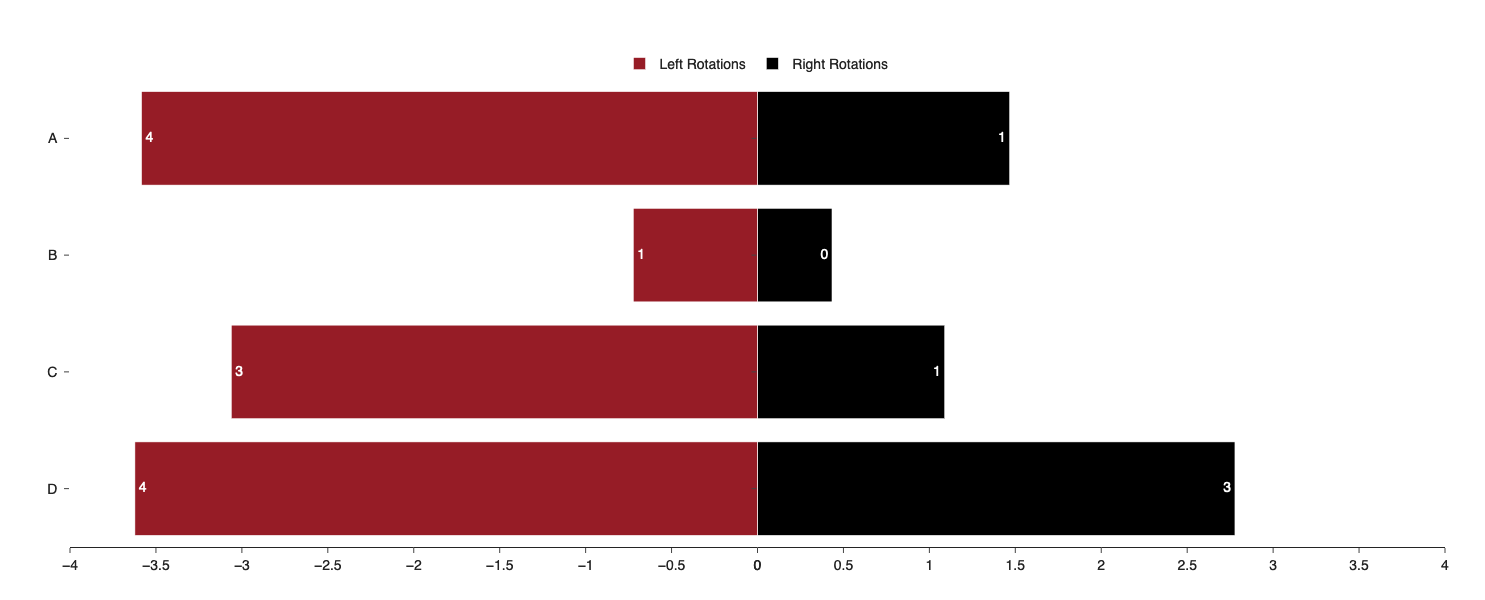

In [11]:
fig_looks = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_yaxes=True, horizontal_spacing=0)
fig_looks.append_trace(go.Bar(x= - df_means_situations.left_looks, y=df_means_situations.situation,
                        orientation='h', showlegend=True, 
                        text= np.round(df_means_situations.left_looks,decimals = 0), 
                        name='Left Rotations',
                        marker_color=marking_red), 1, 1)
fig_looks.append_trace(go.Bar(x=df_means_situations.right_looks, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text=np.round(df_means_situations.right_looks,decimals = 0),
                        name='Right Rotations', marker_color='#000000'), 1, 2)
fig_looks.update_xaxes(showgrid=False,range=[-4,0],row=1, col=1)
fig_looks.update_xaxes(showgrid=False,range=[0,4],row=1, col=2)
fig_looks.update_yaxes(showgrid=False, categoryorder="category descending", ticksuffix=' ', showline=False)
fig_looks.update_traces(hovertemplate=None)
fig_looks.update_layout(
#    title='Mean of Headrotations per Situation',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title='', 
    yaxis_title="",
    width=800, height=600,
    font=dict(family="Lato, sans-serif",size=14),
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')

#### Headrotation Angles

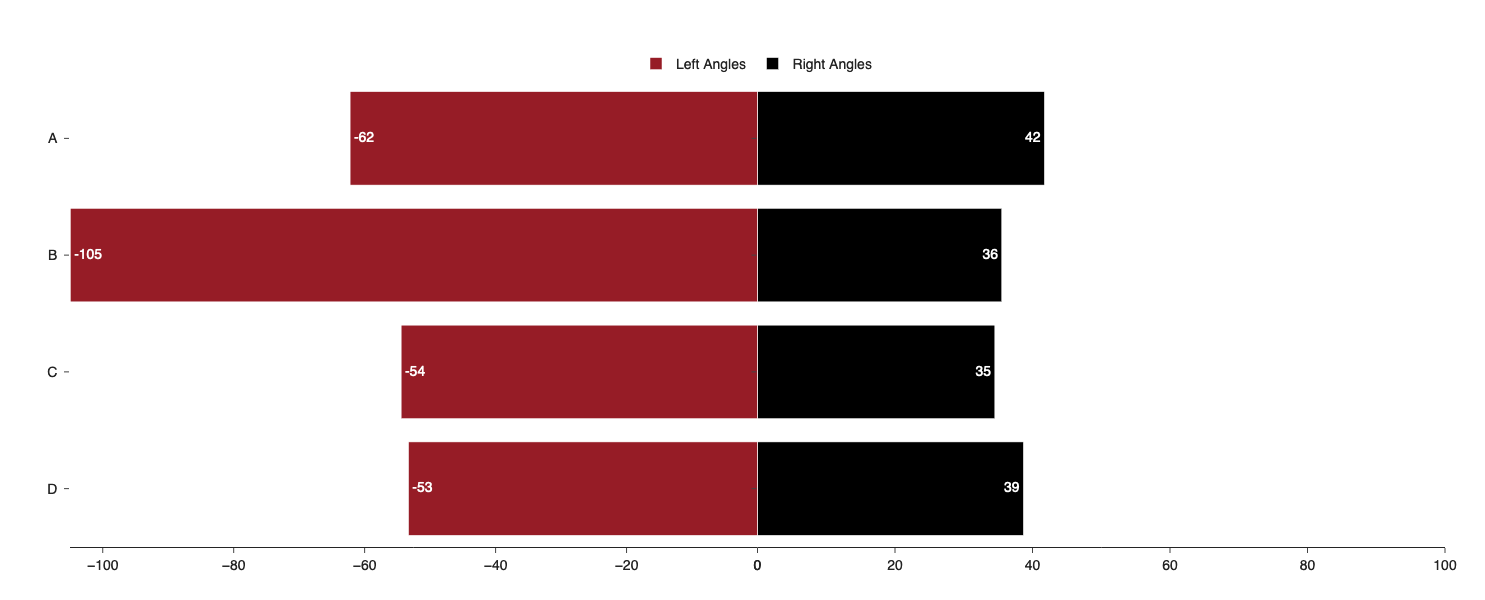

In [12]:
fig_angles = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_yaxes=True, horizontal_spacing=0)
fig_angles.append_trace(go.Bar(x= df_means_situations.left_angles, y=df_means_situations.situation,
                        orientation='h', showlegend=True, 
                        text= np.round(df_means_situations.left_angles,decimals = 0), 
                        name='Left Angles',
                        marker_color=marking_red), 1, 1)
fig_angles.append_trace(go.Bar(x=df_means_situations.right_angles, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text=np.round(df_means_situations.right_angles,decimals = 0),
                        name='Right Angles', marker_color='#000000'), 1, 2)
fig_angles.update_xaxes(showgrid=False,range=[-105,0],row=1, col=1)
fig_angles.update_xaxes(showgrid=False,range=[0,100],row=1, col=2)
fig_angles.update_yaxes(showgrid=False, categoryorder="category descending", 
                 ticksuffix=' ', showline=False)
fig_angles.update_traces(hovertemplate=None)
fig_angles.update_layout(
#    title='Mean Headrotation Angles per Situation',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title=' ', 
    yaxis_title=" ",
    width=800, height=600,
    font=dict(family="Lato, sans-serif",size=14),
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')

In [13]:
### Safety

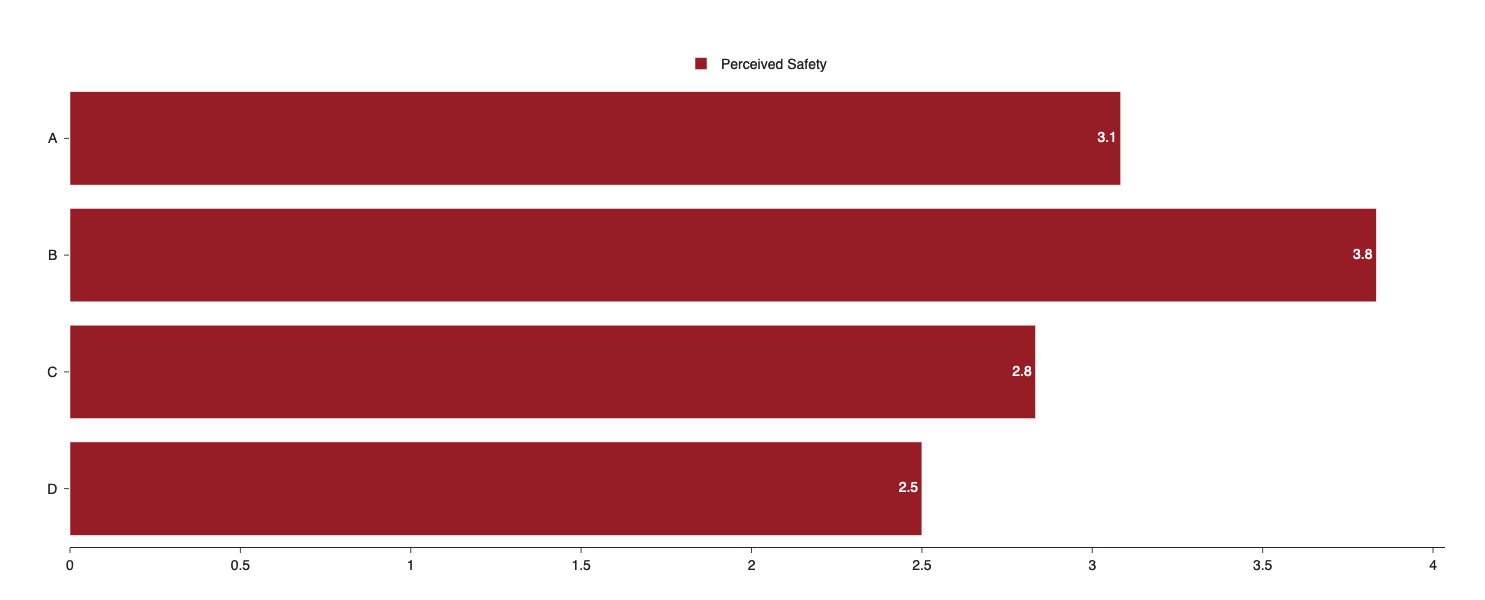

In [31]:
fig_duration = go.Figure()
fig_duration.add_trace(go.Bar(x=df_means_situations.safety, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text=np.round(df_means_situations.safety,decimals = 1),
                        name='Perceived Safety', marker_color= marking_red))
fig_duration.update_xaxes(showgrid=False)
fig_duration.update_yaxes(showgrid=False, categoryorder="category descending",
                 ticksuffix=' ', showline=False)
fig_duration.update_traces(hovertemplate=None)
fig_duration.update_layout(
#    title='Mean of Duration & Standingtimes per Situation (Seconds)(Field)',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title=' ', yaxis_title=" ",
    width=800, height=600,
    font=dict(family="Lato, sans-serif",size=14),
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

#### Collisions

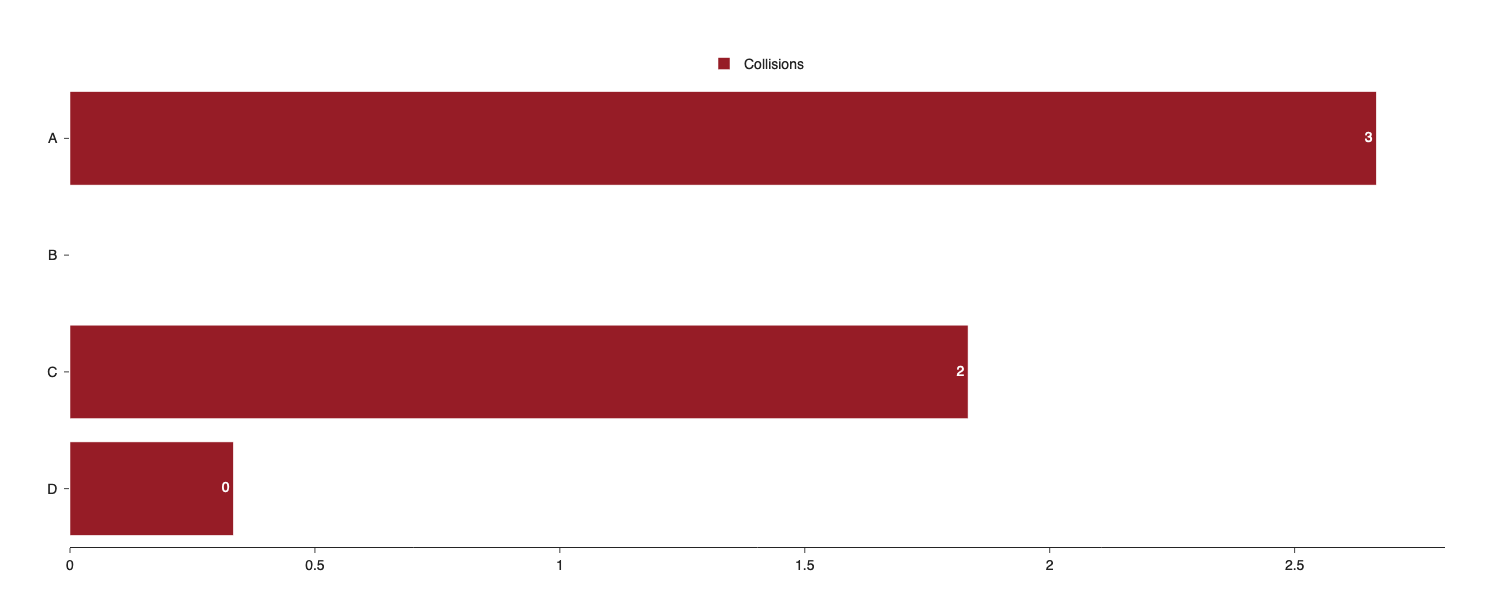

In [15]:
fig_collisions = go.Figure(layout=layout)
fig_collisions.add_trace(go.Bar(x=df_means_situations.collisions, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text=np.round(df_means_situations.collisions,decimals = 0),
                        name='Collisions', marker_color= marking_red))
fig_collisions.update_xaxes(showgrid=False)
fig_collisions.update_yaxes(showgrid=False, categoryorder="category descending",
                 ticksuffix=' ', showline=False)
fig_collisions.update_traces(hovertemplate=None)
fig_collisions.update_layout(
#    title='Mean of Collisions per Situation',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title=' ', 
    yaxis_title=" ",
    font=dict(family="Lato, sans-serif",size=14),
    width=800, height=600,
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"))

#### Duration per Situation

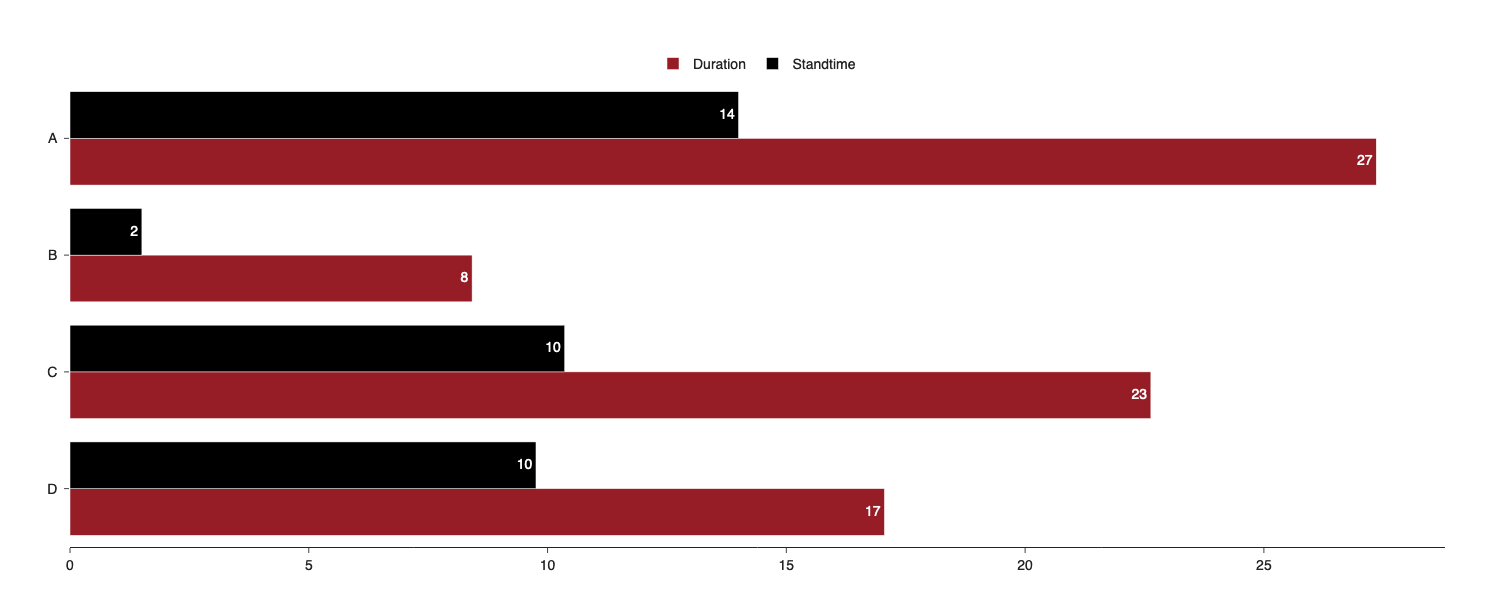

In [16]:
fig_duration = go.Figure(layout=layout)
fig_duration.add_trace(go.Bar(x=df_means_situations.duration, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text= np.round(df_means_situations.duration,decimals = 0),
                        name='Duration', marker_color= marking_red))
fig_duration.add_trace(go.Bar(x=df_means_situations.standtime, y=df_means_situations.situation, 
                        orientation='h', showlegend=True,
                        text=np.round(df_means_situations.standtime,decimals = 0),
                        name='Standtime', marker_color='#000000'))
fig_duration.update_xaxes(showgrid=False)
fig_duration.update_yaxes(showgrid=False, categoryorder="category descending",
                 ticksuffix=' ', showline=False)
fig_duration.update_traces(hovertemplate=None)
fig_duration.update_layout(
#    title='Mean of Duration & Standingtimes per Situation (Seconds)',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title=' ', 
    yaxis_title=" ",
    font=dict(family="Lato, sans-serif",size=14),
    width=800, height=600,
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=18, font_family="Lato, sans-serif"))

#### Duration per Subject

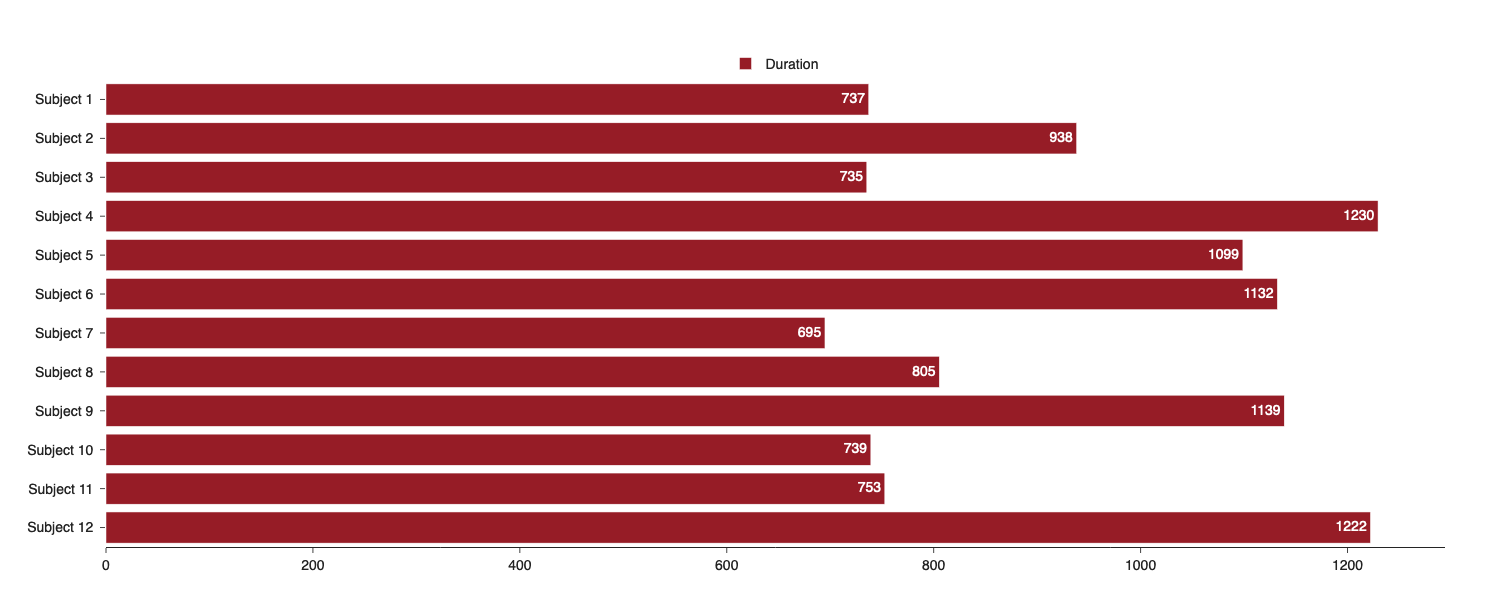

In [17]:
fig_duration_subject = go.Figure(layout=layout)
fig_duration_subject.add_trace(go.Bar(
    x = df_all.duration, 
    y = df_all.subject, 
    orientation='h', 
    showlegend=True,
    text=np.round(df_all.duration,decimals = 0),
    name='Duration', 
    marker_color= marking_red
))
fig_duration_subject.update_xaxes(showgrid=False)
fig_duration_subject.update_yaxes(showgrid=False, categoryorder='array', categoryarray= ["Subject 12","Subject 11","Subject 10","Subject 9","Subject 8","Subject 7","Subject 6","Subject 5","Subject 4","Subject 3","Subject 2","Subject 1"],
                 ticksuffix=' ', showline=False)
fig_duration_subject.update_traces(hovertemplate=None)
fig_duration_subject.update_layout(
#    title='Duration per Subject (Seconds)',
    margin=dict(t=80, b=0, l=70, r=40),
    hovermode="y unified", 
    xaxis_title=' ',
    yaxis_title=" ",
    width=800, height=600,
    font=dict(family="Lato, sans-serif",size=14),
    legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
    hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"))

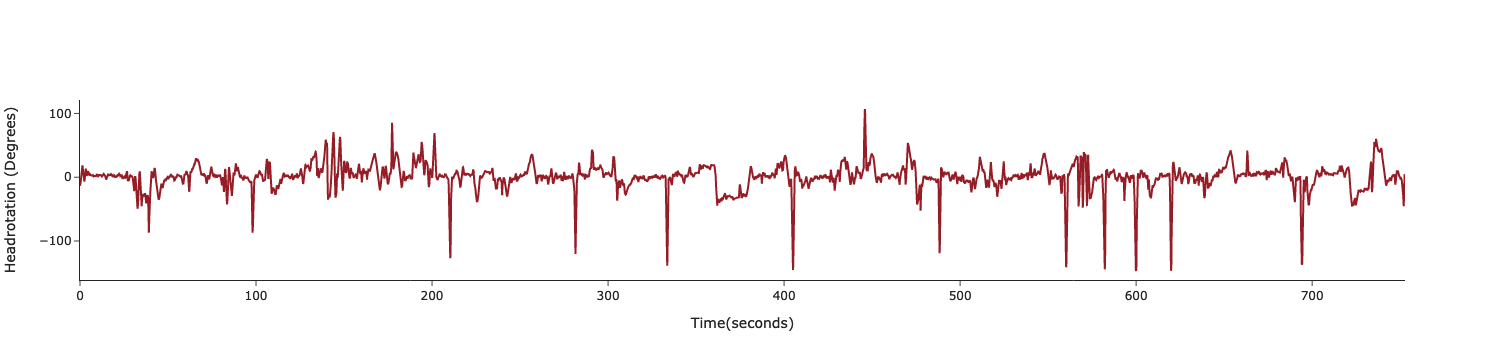

In [18]:
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=subjects["Subject 11"].index,
    y=subjects["Subject 11"]["hmdRotationY"],
    mode="lines",
    name="Headrotation (relative Yaw)",
    line=dict(color=marking_red))
)
fig.update_layout(
    autosize=True,
    hovermode='closest'
)
#add_conditions("Subject 11",fig,"hmdRotationY")
fig.update_xaxes(title_text='Time(seconds)')
fig.update_yaxes(title_text='Headrotation (Degrees)')
display(fig)

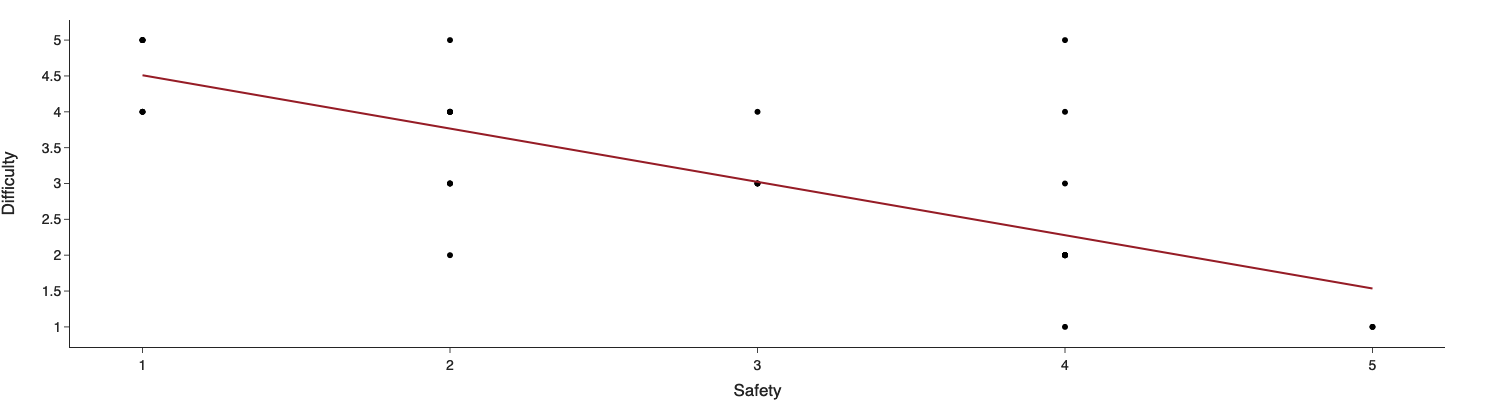

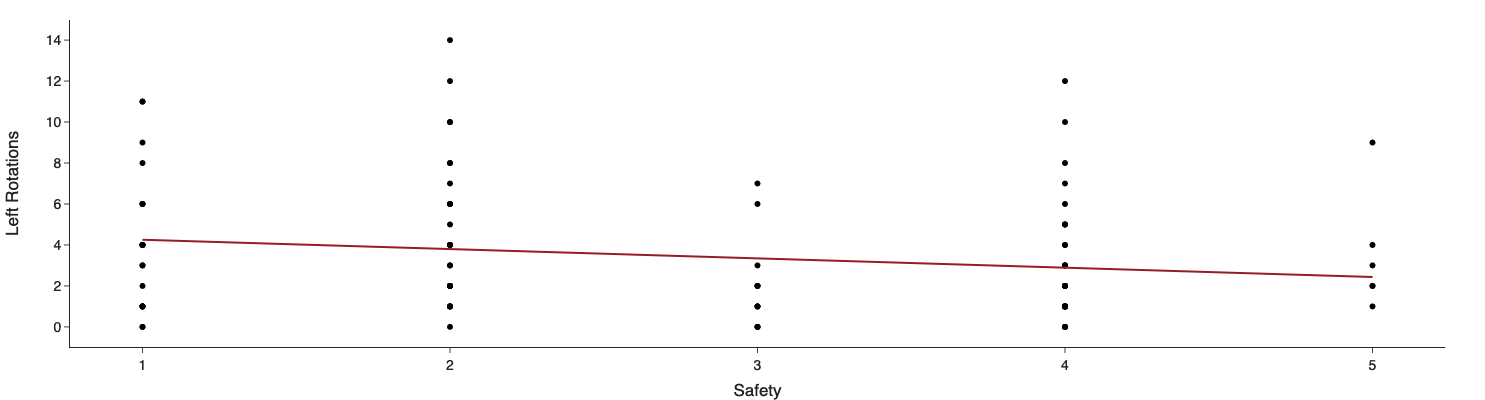

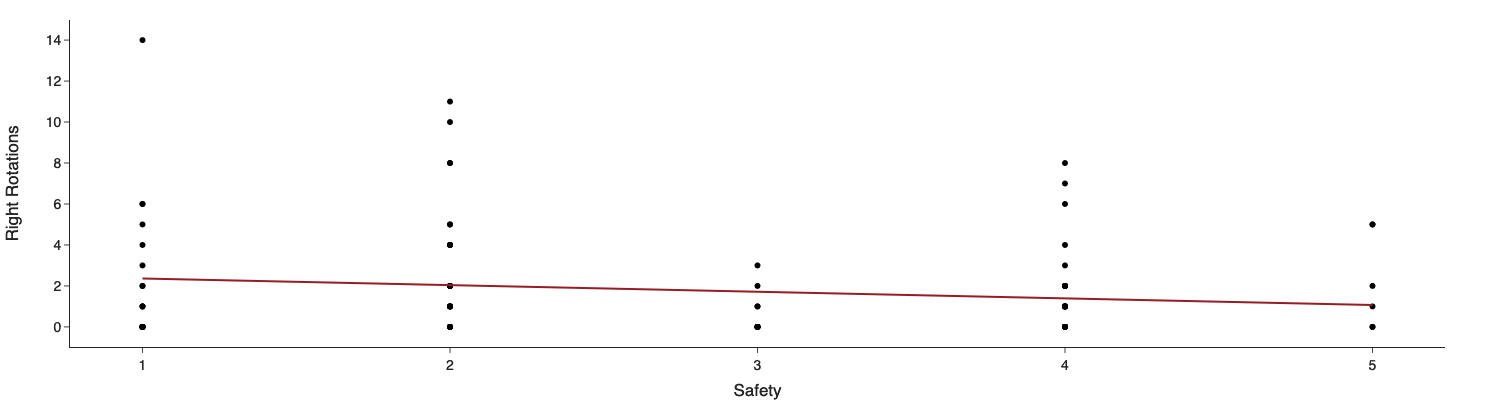

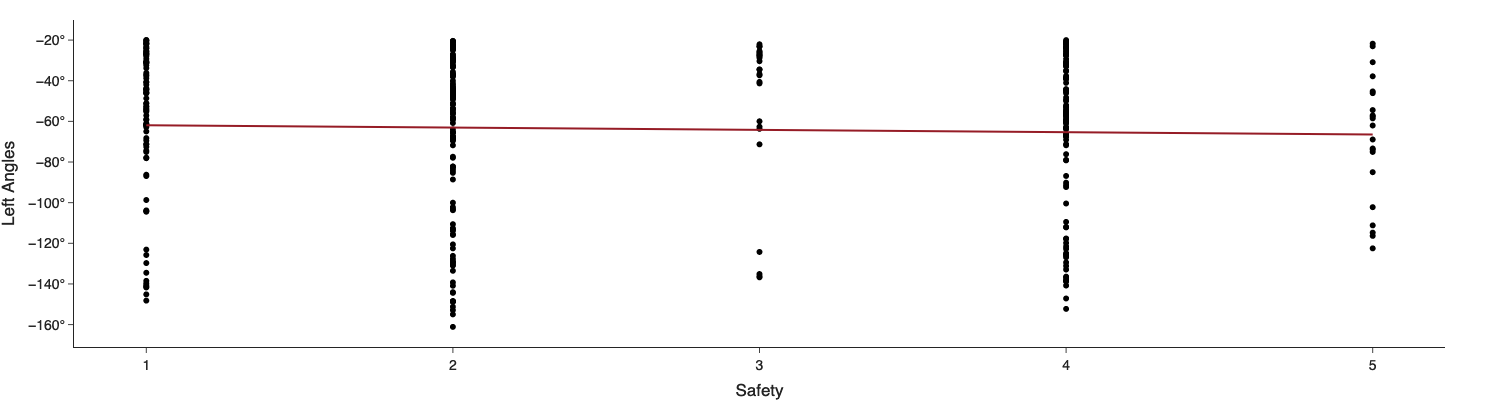

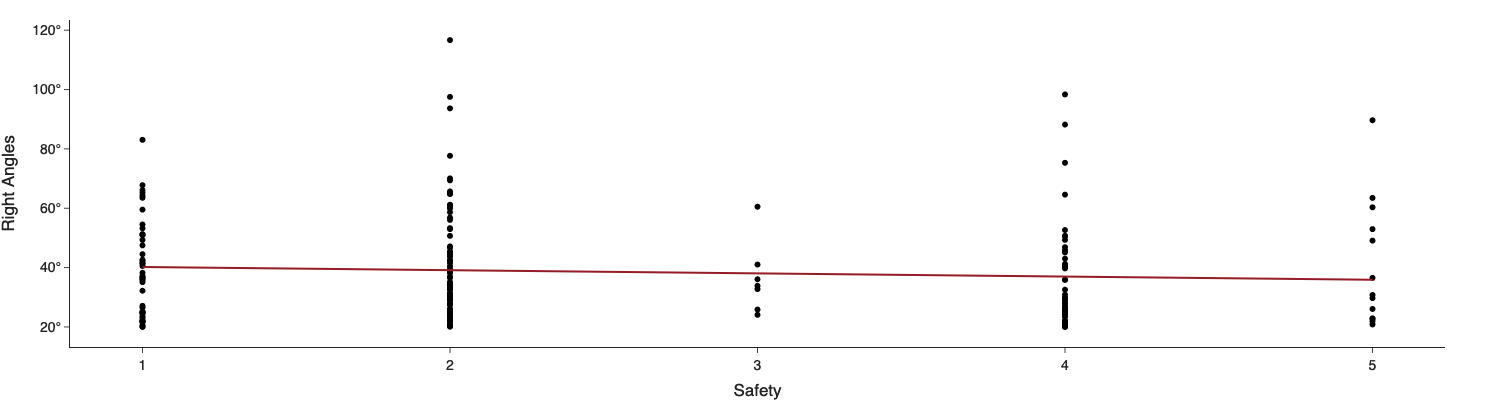

In [19]:
fig_corr_diff = go.Figure(layout=layout)
fig_corr_diff.add_trace(go.Scatter(mode='markers',x = safety,y = difficulty,showlegend=False,name='Safety X Difficulty', marker_color='#000000'))
trend_difficulty = px.scatter(y=difficulty, x= safety, trendline="ols")
trendline = trend_difficulty.data[1]
trendline.marker.color = marking_red
fig_corr_diff.add_trace(trendline)

#Rotations
fig_corr_rleft = go.Figure(layout=layout)
fig_corr_rleft.add_trace(go.Scatter(mode='markers',x = safety_left_rots,y = left_rots,showlegend=False,name='Safety X Left Rotations', marker_color='#000000'))
trend_rotations = fig = px.scatter(y=left_rots, x= safety_left_rots, trendline="ols")
trendline = trend_rotations.data[1]
trendline.marker.color = marking_red
fig_corr_rleft.add_trace(trendline)

fig_corr_rRight = go.Figure(layout=layout)
fig_corr_rRight.add_trace(go.Scatter(mode='markers',x = safety_right_rots,y = right_rots,showlegend=False,name='Safety X Left Rotations', marker_color='#000000'))
trend_rotations = fig = px.scatter(y=right_rots, x= safety_right_rots, trendline="ols")
trendline = trend_rotations.data[1]
trendline.marker.color = marking_red
fig_corr_rRight.add_trace(trendline)

#Angles
fig_corr_aLeft = go.Figure(layout=layout)
fig_corr_aLeft.add_trace(go.Scatter(mode='markers',x = safety_left_angles,y = left_angles,showlegend=False,name='Safety X Left Angles', marker_color='#000000'))
trend_angles = fig = px.scatter(y=left_angles, x= safety_left_angles, trendline="ols")
trendline = trend_angles.data[1]
trendline.marker.color = marking_red
fig_corr_aLeft.add_trace(trendline)

fig_corr_aRight = go.Figure(layout=layout)
fig_corr_aRight.add_trace(go.Scatter(mode='markers',x = safety_right_angles,y = right_angles,showlegend=False,name='Safety X Left Angles', marker_color='#000000'))
trend_angles = fig = px.scatter(y=right_angles, x= safety_right_angles, trendline="ols")
trendline = trend_angles.data[1]
trendline.marker.color = marking_red
fig_corr_aRight.add_trace(trendline)


yaxis = ["Difficulty","Left Rotations","Right Rotations","Left Angles","Right Angles"]
yFormat = ["","","","°","°"]
for index,fig in enumerate([fig_corr_diff,fig_corr_rleft,fig_corr_rRight,fig_corr_aLeft,fig_corr_aRight]):
    fig.update_layout(
    #    title='Mean of Headrotations per Situation(Field)',
        margin=dict(t=20, b=0, l=70, r=40),
        hovermode="y unified", 
        xaxis_title='Safety', 
        xaxis_dtick = 1,
        yaxis_title=yaxis[index],
        yaxis_ticksuffix = yFormat[index],
        width=600, height=400,
        font=dict(family="Lato, sans-serif",size=14),
        legend=dict(orientation="h", yanchor="bottom",y=1, xanchor="center", x=0.5),
        hoverlabel=dict(font_size=13, font_family="Lato, sans-serif"))
    display(fig)

In [20]:
display("Difficulty {}".format(pearsonr(difficulty,safety)))
display("Left Looks {}".format(pearsonr(safety_left_rots, left_rots)))
display("Right Looks {}".format(pearsonr(safety_right_rots, right_rots)))
display("Left angles {}".format(pearsonr(safety_left_angles, left_angles)))
display("Right Angles {}".format(pearsonr(safety_right_angles, right_angles)))

display("Difficulty {}".format(spearmanr(difficulty,safety)))
display("Left Looks {}".format(spearmanr(safety_left_rots, left_rots)))
display("Right Looks {}".format(spearmanr(safety_right_rots, right_rots)))
display("Left angles {}".format(spearmanr(safety_left_angles, left_angles)))
display("Right Angles {}".format(spearmanr(safety_right_angles, right_angles)))


display("Difficulty {}".format(kendalltau(difficulty,safety)))
display("Left Looks {}".format(kendalltau(safety_left_rots, left_rots)))
display("Right Looks {}".format(kendalltau(safety_right_rots, right_rots)))
display("Left angles {}".format(kendalltau(safety_left_angles, left_angles)))
display("Right Angles {}".format(kendalltau(safety_right_angles, right_angles)))

'Difficulty (-0.7607513436010478, 7.255627433270673e-08)'

'Left Looks (-0.1828136428253642, 0.05592683573645308)'

'Right Looks (-0.15490472011165793, 0.10612357940751822)'

'Left angles (-0.03831366608327721, 0.45765819179136025)'

'Right Angles (-0.07712255373374621, 0.2826386982684247)'

'Difficulty SpearmanrResult(correlation=-0.7612622502030594, pvalue=7.026968626460956e-08)'

'Left Looks SpearmanrResult(correlation=-0.16399735983510189, pvalue=0.08690005728887812)'

'Right Looks SpearmanrResult(correlation=-0.10119275163338996, pvalue=0.29284658634090205)'

'Left angles SpearmanrResult(correlation=-0.054636369473177876, pvalue=0.28936033853914483)'

'Right Angles SpearmanrResult(correlation=-0.11502337613830879, pvalue=0.1084146363761208)'

'Difficulty KendalltauResult(correlation=-0.7022177822978937, pvalue=4.663398985377044e-07)'

'Left Looks KendalltauResult(correlation=-0.12842194580096528, pvalue=0.09105065031961908)'

'Right Looks KendalltauResult(correlation=-0.08514929829397272, pvalue=0.28073892837895986)'

'Left angles KendalltauResult(correlation=-0.039603157207070944, pvalue=0.30520214926374056)'

'Right Angles KendalltauResult(correlation=-0.08944909716579051, pvalue=0.09824116474312461)'

## App Layout

In [21]:
app.layout = html.Div([
    html.Div([dcc.Markdown('''### VR Study''',id='headline_subject')],style={'width': '100%', 'display': 'block'}),
    html.Div([dcc.Markdown('''#### General Plots 
    > This data represents the mean values from ALL Subjects''')],style={'width': '100%', 'display': 'block'}),
    html.Div([dcc.Graph(figure = fig_looks)], style={'width': '50%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(figure = fig_angles)], style={'width': '50%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(figure = fig_collisions)], style={'width': '50%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(figure = fig_duration)], style={'width': '50%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(figure = fig_duration_subject)], style={'width': '50%', 'display': 'inline-block'}),
        html.Div([dcc.Markdown('''#### Subject Specific Plots
    > This data represents the selected subject only''')],style={'width': '100%', 'display': 'block'}),
    html.Div([
        html.Label('Subject'),
        dcc.Dropdown(
            id='filter_subject',
            options=[{'label': i, 'value': i} for i in available_data_labels],
            value='Choose Subject '
    )],style={'width': '100%', 'display': 'inline-block'}),
    html.Div([
        html.Label('Timestamp (Seconds)'),
        dcc.Slider(
            id='filter-slider-timestamp',
            min=0,
            max=0,
            value=0,
            tooltip={"placement": "bottom", "always_visible": True},
            step=60
        )
    ], style={'width': '100%', 'display': 'inline-block'}),
    html.Div([
        html.Label('NO Condition',style={'backgroundColor' : COLOR_SIT_X_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
        html.Label('Condition A',style={'backgroundColor' : COLOR_SIT_A_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
        html.Label('Condition B',style={'backgroundColor' : COLOR_SIT_B_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
        html.Label('Condition C',style={'backgroundColor' : COLOR_SIT_C_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
#        html.Label('Condition D',style={'backgroundColor' : COLOR_SIT_D_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
        html.Label('Condition E',style={'backgroundColor' : COLOR_SIT_E_HEX,'color': "#FFFFFF",'borderRadius':'5px','marginLeft':'10px','padding': '10px'}),
    ], style={'width': '100%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(id='headmovement-scatter',hoverData={'points': [{'x': 0}]})], style={'width': '100%', 'display': 'block'}),
    html.Div([dash_table.DataTable(
        id='data_table',
        columns=[{"name": "Situation", "id": "sit", "presentation": "markdown"},
                 {"name": "Collisions", "id": "colisions", "presentation": "input"},
                 {"name": "Head moved left", "id": "leftHead", "presentation": "markdown"},
                 {"name": "Head moved right", "id": "rightHead", "presentation": "markdown"},
                 {"name": "Time 1", "id": "t_1", "presentation": "input"},
                 {"name": "Time 2", "id": "t_2", "presentation": "input"},
                 {"name": "Time 3", "id": "t_3", "presentation": "input"},
                 {"name": "average", "id": "average", "presentation": "input"}],
        data=[{"sit": 'A'},{"sit": 'B'},{"sit": 'C'},{"sit": 'D'},{"sit": 'E'}],
    )], style={'width': '100%', 'display': 'inline-block'}),
    html.Div([dcc.Graph(id='rolls-scatter',hoverData={'points': [{'x': 0}]})], style={'width': '100%', 'display': 'block'}),
    html.Div([dcc.Graph(id='pitchs-scatter',hoverData={'points': [{'x': 0}]})], style={'width': '100%', 'display': 'block'}),
    html.Div([dcc.Graph(id='velocity')], style={'display': 'inline-block', 'width': '50%'}),
    html.Div([dcc.Graph(id='acceleration')], style={'display': 'inline-block', 'width': '50%'})
])

## Callback

### Headline

In [22]:
@app.callback(
    dash.dependencies.Output('headline_subject', 'children'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_headline(subject):
    if not subject in subjects:
        return "### VR Study"
    return "### VR Study : " + subject

### DataTable

In [23]:
@app.callback(
    dash.dependencies.Output('data_table', 'data'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_dataTable(subject):
    if not subject in subjects:
        return
    return [
        {
            "sit": 'A',
            "colisions" : df_all.loc[df_all["subject"] == subject]["sit_a_collisions"].values[0],
            "t_1" : subject_splits[subject]["a"][0][1] - subject_splits[subject]["a"][0][0],
            "t_2" : subject_splits[subject]["a"][1][1] - subject_splits[subject]["a"][1][0],
            "t_3" : subject_splits[subject]["a"][2][1] - subject_splits[subject]["a"][2][0],
            "average" : getAverageOfSplit("a",subject),
            "leftHead": df_all.loc[df_all["subject"] == subject]["sit_a_left_rotations"].values[0],
            "rightHead": df_all.loc[df_all["subject"] == subject]["sit_a_right_rotations"].values[0]
        },
        {
            "sit": 'B',
            "colisions" : df_all.loc[df_all["subject"] == subject]["sit_b_collisions"].values[0],
            "t_1" : subject_splits[subject]["b"][0][1] - subject_splits[subject]["b"][0][0],
            "t_2" : subject_splits[subject]["b"][1][1] - subject_splits[subject]["b"][1][0],
            "t_3" : subject_splits[subject]["b"][2][1] - subject_splits[subject]["b"][2][0],
            "average" : getAverageOfSplit("b",subject),
            "leftHead": df_all.loc[df_all["subject"] == subject]["sit_b_left_rotations"].values[0],
            "rightHead": df_all.loc[df_all["subject"] == subject]["sit_c_right_rotations"].values[0]
        },
        {
            "sit": 'C',
            "colisions" : df_all.loc[df_all["subject"] == subject]["sit_c_collisions"].values[0],
            "t_1" : subject_splits[subject]["c"][0][1] - subject_splits[subject]["c"][0][0],
            "t_2" : subject_splits[subject]["c"][1][1] - subject_splits[subject]["c"][1][0],
            "t_3" : subject_splits[subject]["c"][2][1] - subject_splits[subject]["c"][2][0],
            "average" : getAverageOfSplit("c",subject),
            "leftHead": df_all.loc[df_all["subject"] == subject]["sit_c_left_rotations"].values[0],
            "rightHead": df_all.loc[df_all["subject"] == subject]["sit_c_right_rotations"].values[0]
        },
#        {
#            "sit": 'D'
#        },
        {
            "sit": 'E',
            "colisions" : df_all.loc[df_all["subject"] == subject]["sit_e_collisions"].values[0],
            "t_1" : subject_splits[subject]["e"][0][1] - subject_splits[subject]["e"][0][0],
            "t_2" : subject_splits[subject]["e"][1][1] - subject_splits[subject]["e"][1][0],
            "t_3" : subject_splits[subject]["e"][2][1] - subject_splits[subject]["e"][2][0],
            "average" : getAverageOfSplit("e",subject),
            "leftHead": df_all.loc[df_all["subject"] == subject]["sit_e_left_rotations"].values[0],
            "rightHead": df_all.loc[df_all["subject"] == subject]["sit_e_right_rotations"].values[0]
        }]

### Timestamps

In [24]:
@app.callback(
    dash.dependencies.Output('filter-slider-timestamp', 'value'),
    [dash.dependencies.Input('filter_subject', 'value')])
#    dash.dependencies.Input('headmovement-scatter', 'hoverData')
def update_timestampValue(subject):
    if not subject in subjects:
        return 0
    
    lastTimestamp = float(subjects[subject].iloc[-1].name)
    #display("The experiment from subject "+infos["subject"]+" lasted " + str(lastTimestamp) + " seconds and started at " + infos["starttime"])
    halfminuteSteps = np.arange(0,lastTimestamp,30)
    halfminuteStepLabels = list(map(lambda x: str(int(x)), halfminuteSteps))
    #if "x" in hoverdata['points'][0]:
    #    return hoverdata['points'][0]["x"]
    #else:
    return 0
@app.callback(
    dash.dependencies.Output('filter-slider-timestamp', 'min'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_timestampMin(subject):
    if not subject in subjects:
        return 0
    return subjects[subject].index.min()
@app.callback(
    dash.dependencies.Output('filter-slider-timestamp', 'max'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_timestampMax(subject):
    if not subject in subjects:
        return 0
    return subjects[subject].index.max()

### Headmovement

In [25]:
@app.callback(
    dash.dependencies.Output('headmovement-scatter', 'figure'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_headrotation(subject):
    if not subject in subjects:
        return go.Figure()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subjects[subject].index,
        y=subjects[subject]["hmdRotationY"],
        mode="lines",
        name="Headrotation (relative Yaw)")
    )
    fig.update_layout(
        title_text="Headmovement",
        autosize=True,
        hovermode='closest'
    )
    add_conditions(subject,fig,"hmdRotationY")
    fig.update_xaxes(title_text='Time(seconds)')
    fig.update_yaxes(title_text='Headrotation (Degrees)')

    return fig

### Roll

In [26]:
@app.callback(
    dash.dependencies.Output('rolls-scatter', 'figure'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_rolls(subject):
    if not subject in subjects:
        return go.Figure()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subjects[subject].index,
        y=subjects[subject]["hmdRotationZ"],
        mode="lines",
        name="HmdRotationZ")
    )
    fig.update_layout(
        title_text="Roll (HMDRotationZ)",
        autosize=True,
        hovermode='closest',
    )
    add_conditions(subject,fig,"hmdRotationZ")
    fig.update_xaxes(title_text='Time(seconds)')
    fig.update_yaxes(title_text='Roll (Degrees)')

    return fig

### Pitch

In [27]:
@app.callback(
    dash.dependencies.Output('pitchs-scatter', 'figure'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_pitchs(subject):
    if not subject in subjects:
        return go.Figure()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subjects[subject].index,
        y=subjects[subject]["hmdRotationX"],
        mode="lines",
        name="HmdRotationX")
    )
    fig.update_layout(
        title_text="Pitch (HmdRotationX)",
        autosize=True,
        hovermode='closest'
    )
    add_conditions(subject,fig,"hmdRotationX")
    fig.update_xaxes(title_text='Time(seconds)')
    fig.update_yaxes(title_text='Pitch (Degrees)')

    return fig

### Acceleration

In [28]:
@app.callback(
    dash.dependencies.Output('acceleration', 'figure'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_acceleration(subject):
    if not subject in subjects:
        return go.Figure()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subjects[subject].index,
        y=subjects[subject]["speed"],
        mode="lines")
    )
    fig.update_layout(
        title_text="Acceleration (speed)",
        autosize=True,
        hovermode='closest'
    )
    add_conditions(subject,fig,"speed")
    fig.update_xaxes(title_text='Time (seconds)')
    fig.update_yaxes(title_text='speed')
    return fig

### Velocity

In [29]:
@app.callback(
    dash.dependencies.Output('velocity', 'figure'),
    [dash.dependencies.Input('filter_subject', 'value')])
def update_velocity(subject):
    if not subject in subjects:
        return go.Figure()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subjects[subject].index,
        y=subjects[subject]["velocityY"],
        mode="lines")
    )
    fig.update_layout(
        title_text="Velocity",
        autosize=True,
        hovermode='closest'
    )
    add_conditions(subject,fig,"velocityY")
    fig.update_xaxes(title_text='Time (seconds)')
    fig.update_yaxes(title_text='Velocity Y (km/h)')

    return fig

## Run Server

In [30]:
app.run_server(mode='external', port = 8091, dev_tools_ui=True, debug=True,dev_tools_hot_reload =True, threaded=True)

Dash app running on http://127.0.0.1:8091/
